In [243]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

In [244]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(10,5)})

In [298]:
n_steps = 64

n=64
v=10
d=8

w_shape = (d,d)
a_shape = (v,v)
f_shape = (n,v,d)

In [299]:
def diffusion_step(F,A,W,tau=1):
    return tau*np.einsum('kv,nvd -> nkd',A,np.einsum('nvd,dk -> nvk',F,W)) + F

def diffusion_stepFT(F,A,W,tau=0.5):
    return tau*np.einsum('kv,nvd -> nkd',A,np.einsum('nvd,dk -> nvk',F,W)) + (1-tau)*F

def diffusion_stepI(F,A,W,tau=1):
    return tau*np.einsum('kv,nvd -> nkd',A-np.eye(A.shape[0]),np.einsum('nvd,dk -> nvk',F,W)) + F

def diffuse(F0,As,Ws,step_fn,tau=1):
    assert len(As) == len(Ws), "As and Ws must be of same length"
    
    outputs = [F0]
    for A,W in zip(As,Ws):
        outputs.append(step_fn(outputs[-1],A,W,tau))
    
    return outputs

def get_similarities(outputs):
    similarities = []
    batch_size = outputs[0].shape[0]
    dim = outputs[0].shape[1]
    for output in outputs:
        similarities.append(
            np.sum(np.fromiter((cosine_similarity(output[k]).mean() for k in range(dim)), float))/batch_size
        )
        
    return similarities 

def plot_similarities(sims):
    plt.plot(sims, linestyle=':', marker='P', markersize=5)
    plt.ylabel("Average node similarities")
    plt.xlabel("Diffusion steps")
    plt.show()
    
def get_differences(outputs):
    differences = []
    for k in range(len(outputs)-1):
        differences.append(np.max(outputs[k+1]-outputs[k]))
        
    return differences 

def plot_differences(diffs):
    plt.plot(diffs, linestyle=':', marker='P', color='r', markersize=5)
    plt.ylabel("Max node difference")
    plt.xlabel("Diffusion steps")
    plt.show()

# $\mathbf{F}(t+1) = \tau \mathbf{A}(\mathbf{F}(t))\mathbf{F}(t)\mathbf{W}(t) + \mathbf{F}(t)$

In [312]:
As =[
    scipy.special.softmax(np.random.normal(0,1,a_shape), axis=0) for _ in range(n_steps)
]

Ws =[
    np.random.normal(0,0.1,w_shape) for _ in range(n_steps)
]
## negative eigenvalues
#for W in Ws: W = 0.5*(W+W.T)

F0 = np.random.normal(0,1,f_shape)

In [313]:
eigs = np.linalg.eigvals(Ws[0])
for e in eigs: print(e)

(0.3218306746297232+0.12360107980716739j)
(0.3218306746297232-0.12360107980716739j)
(0.20845941709330987+0.1933260696287316j)
(0.20845941709330987-0.1933260696287316j)
(-0.07467670322048871+0.07481298580485099j)
(-0.07467670322048871-0.07481298580485099j)
(0.07751660223896502+0.09845816957034567j)
(0.07751660223896502-0.09845816957034567j)


In [314]:
outputs = diffuse(F0,As,Ws,diffusion_step,tau=1)

## Oversmoothing

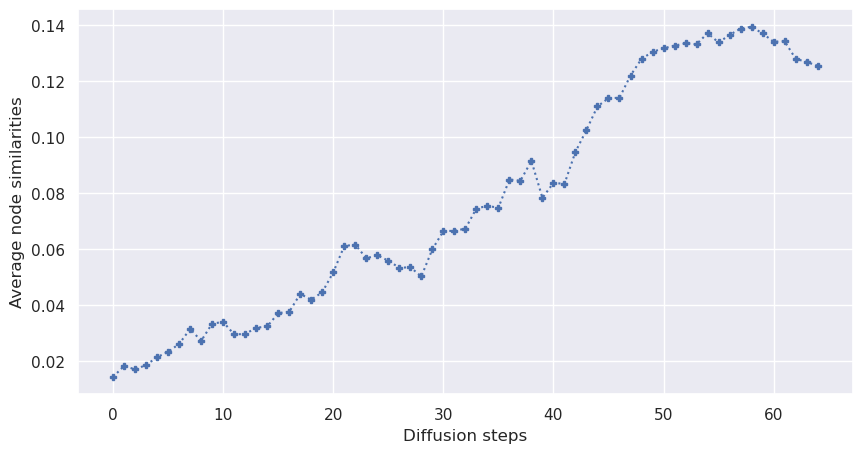

In [315]:
similarities = get_similarities(outputs)
plot_similarities(similarities)

## Stability

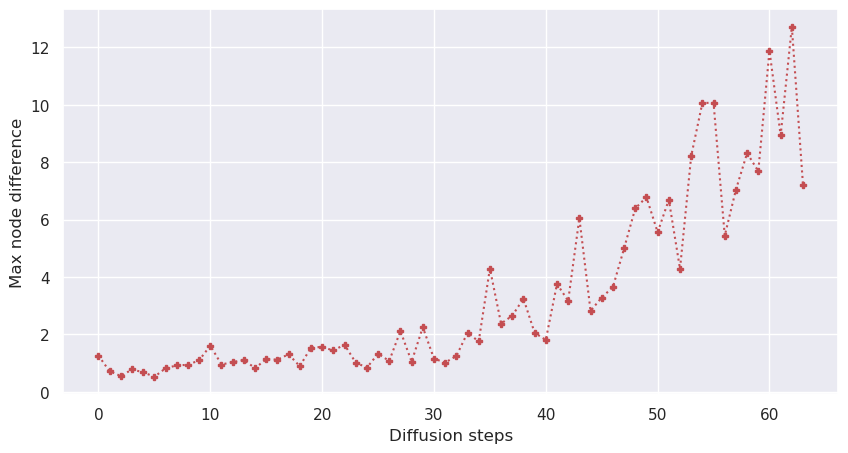

In [316]:
differences = get_differences(outputs)
plot_differences(differences)

# $\mathbf{F}(t+1) = \tau \mathbf{A}(\mathbf{F}(t))\mathbf{F}(t)\mathbf{W}(t) + (1 - \tau) \mathbf{F}(t)$

In [317]:
As =[
    scipy.special.softmax(np.random.normal(0,1,a_shape), axis=0) for _ in range(n_steps)
]

Ws =[
    scipy.special.softmax(np.random.normal(0,0.1,w_shape), axis=1)/w_shape[1] for _ in range(n_steps)
]
#for W in Ws: W = 0.5*(W+W.T)

F0 = np.random.normal(0,1,f_shape)

In [318]:
eigs = np.linalg.eigvals(Ws[0])
for e in eigs: print(e)

(0.12500000000000008+0j)
(-0.0015204784060387907+0.0030085071458826012j)
(-0.0015204784060387907-0.0030085071458826012j)
(0.001350893555312275+0.0035807144344219854j)
(0.001350893555312275-0.0035807144344219854j)
(0.003414709092857083+0j)
(0.0006007658708873681+0.000743152388455295j)
(0.0006007658708873681-0.000743152388455295j)


In [319]:
outputs = diffuse(F0,As,Ws,diffusion_stepFT,tau=0.5)

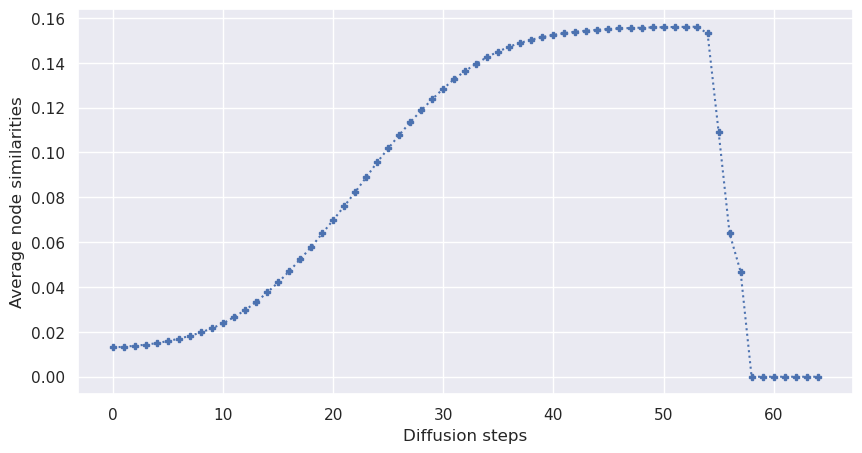

In [320]:
similarities = get_similarities(outputs)
plot_similarities(similarities)

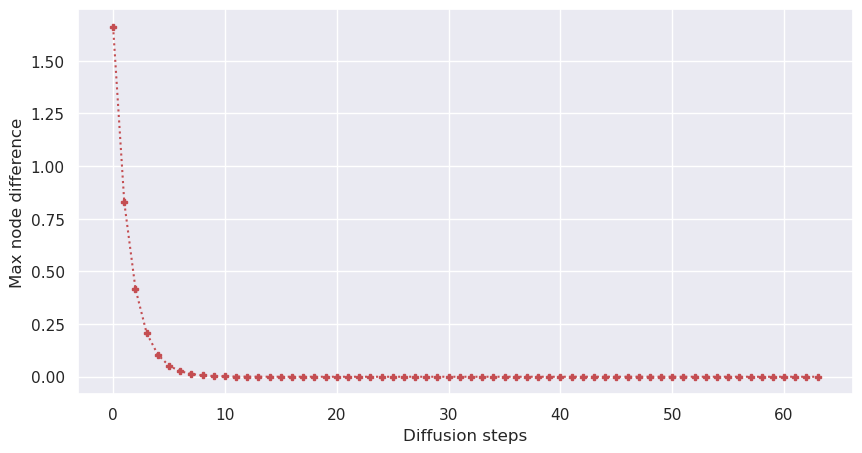

In [321]:
differences = get_differences(outputs)
plot_differences(differences)

In [285]:
outputs = diffuse(F0,As,Ws,diffusion_stepFT,tau=1)

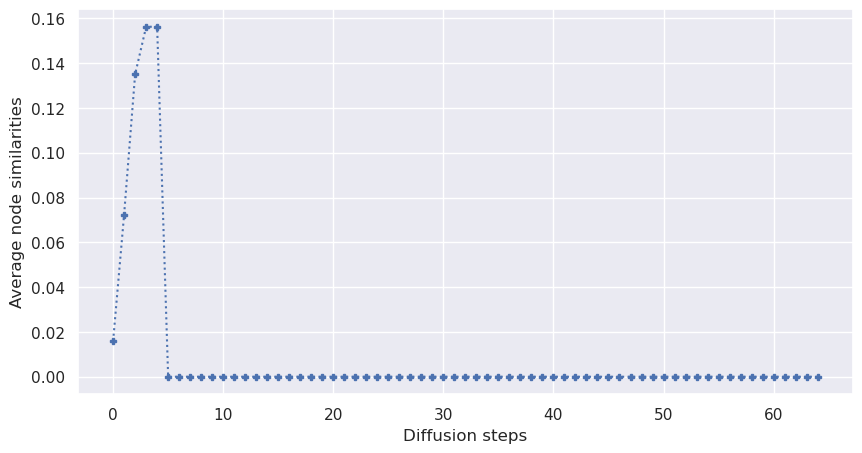

In [286]:
similarities = get_similarities(outputs)
plot_similarities(similarities)

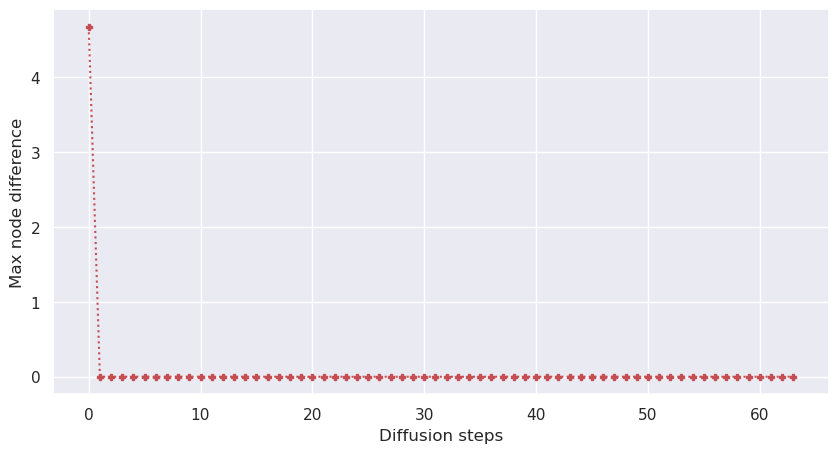

In [287]:
differences = get_differences(outputs)
plot_differences(differences)

# $\mathbf{F}(t+1) = \tau \bar{\mathbf{A}}(\mathbf{F}(t))\mathbf{F}(t)\mathbf{W}(t) + \mathbf{F}(t)$

In [291]:
outputs = diffuse(F0,As,Ws,diffusion_stepI,tau=1)

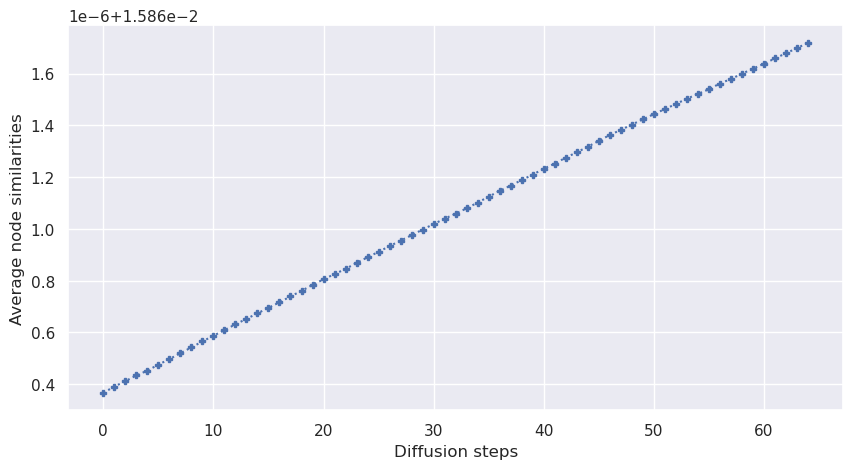

In [292]:
similarities = get_similarities(outputs)
plot_similarities(similarities)

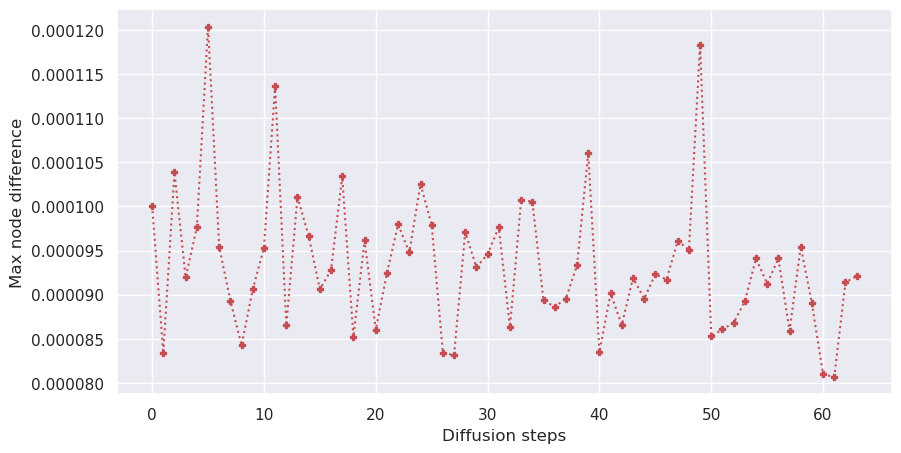

In [293]:
differences = get_differences(outputs)
plot_differences(differences)